In [45]:
%matplotlib inline 

from os.path import join
import json

from rasterio.plot import show
import rasterio
import matplotlib.pyplot as plt
import xmltodict
from shapely.geometry import Polygon
import numpy as np
from shapely.geometry import mapping

In [57]:
data_dir = '/opt/data/nih-histo/eosinophil-data/'
img_path = join(data_dir, '41.tiff')
label_path = join(data_dir, '41-labels.tiff')
fov_path = join(data_dir, '41.xml')

In [58]:
img_src = rasterio.open(img_path)
img_shape = img_src.shape
img_shape

(27000, 33505)

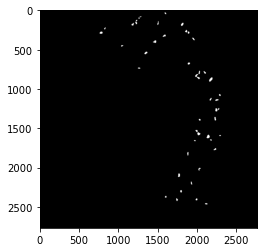

In [60]:
src = rasterio.open(label_path)
label_arr = src.read(1)
plt.imshow(label_arr, cmap='gray')

In [61]:
# These vertices described the blue dashed circle shown in the images above for #32 and #22076. These are expressed in millimeters where the center of the image is (0 mm, 0 mm) and the x-coordinate increases from left to right and the y-coordinate increases from bottom to top.
# How many millimeters are there per pixel? Once I have that piece of information, I should be able to translate these into pixel-based coordinates. I could not find this information precisely, but rather the dots/mm – with is 4000 dots/mm for the images labeled with 5 digits (ex: #22076) and 5000 dots/mm for the images labeled with 1 or 2 digits (ex: 32). Below is a copy of the image information for #22076, as an example.

with open(fov_path) as fd:
    fov_dict = xmltodict.parse(fd.read())
points = fov_dict['LayerData']['Regions']['Object'][1]['Vertices']['Vertex']
fov = [(float(p['@X']), float(p['@Y'])) for p in points]
fov = np.array(fov)
dots_per_mm = 5000
# negate the y dimension so that the value increases as we go down the array
fov[:, 1] *= -1

In [62]:
height, width = img_shape
img_center = np.array([[width, height]]) // 2
img_center

array([[16752, 13500]])

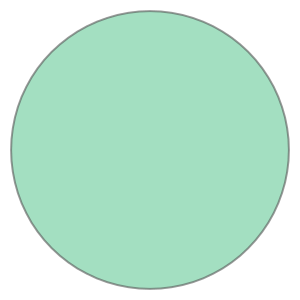

In [73]:
# multiply by scale factor so it's in pixel coordinates and then
# center the cicle: add the position of the center of the image
fov_poly_arr = ((fov * dots_per_mm) + img_center).round().astype(int)
# make Y values negative to display in QGIS. 
# TODO Remove this
fov_poly_arr[:, 1] *= -1
fov_poly = Polygon(fov_poly_arr)
fov_poly

In [66]:
fov_center = np.array(fov_poly.centroid.xy).squeeze()
fov_center

array([21495.77572356, 19445.19936929])

In [67]:
label_height, label_width = label_arr.shape
label_half_width = np.array([label_width, label_height]) // 2
label_offset = (fov_center - label_half_width).astype(np.int32)
label_offset

array([20112, 18062], dtype=int32)

In [68]:
label_overlay = np.zeros(img_shape, dtype=np.uint8)
label_overlay[
    label_offset[1]:label_offset[1] + label_height, 
    label_offset[0]:label_offset[0] + label_width] = label_arr

In [69]:
# save geotiff and check in qgis
# save fov_poly to geojson
# check that all xml files have a single FOV

In [70]:
from rasterio.profiles import DefaultGTiffProfile

profile = DefaultGTiffProfile(count=1, width=label_overlay.shape[1], height=label_overlay.shape[0])
new_label_path = join(data_dir, 'new-labels.tiff')

with rasterio.open(new_label_path, 'w', **profile) as dst:
    dst.write(label_overlay, 1)

In [74]:
aoi_dict = {
    'type': 'FeatureCollection',
    'features': [
        {
            'type': 'Feature',
            'geometry': mapping(fov_poly),
        }
    ]
}

In [75]:
aoi_path = join(data_dir, 'aoi.json')
with open(aoi_path, 'w') as aoi_fd:
    aoi_fd.write(json.dumps(aoi_dict))